<h1 align=center><font color="Black" > Segmenting and Clustering Neighborhoods in the city of Toronto,Canada </font>

### In this notebook, the neighborhoods in the city of Toronto is segmented and clustered based on their similarity.

## Table of Content 
   





<font size=3.5>
   
    
    
1. Part 1 - [Creating DataFrame of Neighborhoods Information for city of Toronto](#top)

2. Part 2 - [Addition of Latitude and Longitude Coordinates](#middle)

3. Part 3 - [Clustering Neighborhood in Toronto](#bottom)
</font>



## **Part 1 - Creating DataFrame of Neighborhoods Information for city of Toronto** <a id='top'></a>

In [164]:
#import all the libraries 
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
!pip install folium==0.5.0
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim

In [2]:
#get the url
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
request=requests.get(url)

In [3]:
#Scrape the information

soup=BeautifulSoup(request.content,'lxml')

data=soup.find(class_='wikitable')

df = pd.read_html(str(data))

In [4]:
#convert into Pandas dataframe
Toronto_Neigh=pd.DataFrame(df[0])
Toronto_Neigh.head(5)

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [5]:
#check the size of the dataFrame
Toronto_Neigh.shape

(180, 3)

In [6]:
#drop the column with the Borough not assigned & reset the index
Toronto_Neigh=Toronto_Neigh[Toronto_Neigh.Borough!='Not assigned']
Toronto_Neigh.reset_index(drop=True, inplace=True)

In [7]:
Toronto_Neigh.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [8]:
# Notice that more than one neighborhood can exists in one postal code area. In the updated version of wikipedia's page, these are combined in single row with the neighborhood separated by /
# Confirm that all postal code area with multiple neighborhood are now combined in single row in the updated version of wikipedia's page
a=Toronto_Neigh['Postal code'].value_counts().to_frame()
a[a['Postal code']>1]

,Postal code


**As shown above, in the updated wikipedia's page, neighborhoods with the same postal code are now combined into the same row, with the neighborhood separated by '/' . To fulfill the assignment's requirement, that is to separate the neighborhood with comma,the following cell is exceuted.**

In [9]:
#to replace '/' with ',' in Neighborhood
Toronto_Neigh['Neighborhood']=Toronto_Neigh['Neighborhood'].str.replace('/',',')
Toronto_Neigh.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [10]:
#Search for row with empty Neighborhood data
Toronto_Neigh[Toronto_Neigh['Neighborhood']==""] 

,Postal code,Borough,Neighborhood


In [11]:
#Search for row with "Not assigned" neighborhood
Toronto_Neigh[Toronto_Neigh['Neighborhood'].str.contains('Not')]

,Postal code,Borough,Neighborhood


**As shown above, there is no empty nor Not Assigned neighborhood column.**

In [12]:
#display the shape of dataframe
Toronto_Neigh.shape

(103, 3)

## **Part 2 - Addition of Latitude and Longitude Coordinates**<a id='middle'></a>

A link to a CSV file that has the geographical coordinates of each postal code is available. 

In [13]:
csv_link='http://cocl.us/Geospatial_data'

In [14]:
#read the csv into a pandas data frame
geo_coor=pd.read_csv(csv_link)
geo_coor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Note that the column name is "Postal Code" in data frame geo_coor, and "Postal code" in data frame Toronto_Neigh. Pre-process the dataframe geo_coor to make the column name consistent with that of Toronto_Neigh

In [15]:
#rename column "Postal Code" to "Postal code" in data frame geo_coor
geo_coor.rename(columns={'Postal Code':'Postal code'},inplace=True)
geo_coor.head()

,Postal code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [16]:
#Merge the dataframe of Toronto_Neigh and geo_coor
Tor_Neig_Coor=pd.DataFrame.join(Toronto_Neigh,geo_coor.set_index("Postal code"),on='Postal code',how='inner')

In [17]:
#Rename column "Postal code" to "PostalCode"
Tor_Neig_Coor.rename(columns={'Postal code':'PostalCode'},inplace=True)
Tor_Neig_Coor.head(15)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


Now, we are ready to explore and cluster neighborhood in Toronto!

## **Part 3 - Clustering Neighborhood in Toronto**<a id='bottom'></a>

Let's narrow our target to only boroughts that contain the word Toronto.

In [156]:
#Search for boroughts that contain the word Toronto
Bor_Tor=Tor_Neig_Coor[Tor_Neig_Coor['Borough'].str.contains('Toronto')]

In [157]:
Bor_Tor.reset_index(drop=True,inplace=True)
Bor_Tor

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,Downtown Toronto,"Richmond , Adelaide , King",43.650571,-79.384568
9,M6H,West Toronto,"Dufferin , Dovercourt Village",43.669005,-79.442259


There are 39 boroughs that contain the word Toronto

Let's define a function to search for top venues & their categories in each neighborhood. We will make access to Foursquare API for this getting these data.

In [21]:
# The code was removed by Watson Studio for sharing.

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function, and put the output into a new data frame.

In [24]:
LIMIT=100

bor_tor_venue= getNearbyVenues(names=Bor_Tor['Neighborhood'],
                                   latitudes=Bor_Tor['Latitude'],
                                   longitudes=Bor_Tor['Longitude']
                                  )

Regent Park , Harbourfront
Queen's Park , Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond , Adelaide , King
Dufferin , Dovercourt Village
Harbourfront East , Union Station , Toronto Islands
Little Portugal , Trinity
The Danforth West , Riverdale
Toronto Dominion Centre , Design Exchange
Brockton , Parkdale Village , Exhibition Place
India Bazaar , The Beaches West
Commerce Court , Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park , The Junction South
North Toronto West
The Annex , North Midtown , Yorkville
Parkdale , Roncesvalles
Davisville
University of Toronto , Harbord
Runnymede , Swansea
Moore Park , Summerhill East
Kensington Market , Chinatown , Grange Park
Summerhill West , Rathnelly , South Hill , Forest Hill SE , Deer Park
CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst  Quay , South Niagara , Island airport
Rosed

**Let's check the size of the resulting data frame.**

In [26]:
print(bor_tor_venue.shape)
bor_tor_venue.head()

(1684, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park , Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park , Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park , Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park , Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park , Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


Let's check how many venues were returned for each neighborhood.

In [27]:
bor_tor_venue.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton , Parkdale Village , Exhibition Place",22,22,22,22,22,22
Business reply mail Processing CentrE,16,16,16,16,16,16
"CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport",18,18,18,18,18,18
Central Bay Street,75,75,75,75,75,75
Christie,18,18,18,18,18,18
Church and Wellesley,79,79,79,79,79,79
"Commerce Court , Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34


Let's check what are the top 5 most common venue categories.

In [40]:
bor_tor_venue['Venue Category'].value_counts().sort_values(ascending=False).head()

Coffee Shop           164
Café                   92
Restaurant             62
Italian Restaurant     45
Park                   36
Name: Venue Category, dtype: int64

Let's check how many unique categories there are in total.

In [36]:
print("There are {} categories in total.".format(len(bor_tor_venue["Venue Category"].unique())))

There are 232 categories in total.


<h3> Lets analyze each neighborhood.

We perform one hot encoding to convert the categorical variables into a form that could be provided to ML algorithms to do a better job in prediction

In [93]:
#One hot encoding
dummy=pd.get_dummies(bor_tor_venue[['Venue Category']],prefix="",prefix_sep="")

#Create dataframe consists of only column Neighborhood
tor_ven_onehot=bor_tor_venue[['Neighborhood']]

# Create a new dataframe consist of column Neighborhood and dummies colmns
tor_ven_onehot=tor_ven_onehot.merge(dummy,left_index=True,right_index=True)

tor_ven_onehot.head()

,Neighborhood_x,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
#rename coumn Neighborhood_x to Neighborhood
tor_ven_onehot.rename(columns={'Neighborhood_x':"Neighborhood"},inplace=True)

**Let's group the row by neighborhood.**

In [145]:
tor_ven_onehot_grouped=tor_ven_onehot.groupby('Neighborhood').mean().reset_index()
tor_ven_onehot_grouped.head(10)

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.017857,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,"Brockton , Parkdale Village , Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
2,Business reply mail Processing CentrE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.062500
3,"CN Tower , King and Spadina , Railway Lands , ...",0.000000,0.055556,0.055556,0.055556,0.111111,0.166667,0.111111,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,0.0,...,0.000000,0.0,0.0,0.013333,0.0,0.0,0.013333,0.000000,0.0,0.013333
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
6,Church and Wellesley,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.012658,0.0,0.025316
7,"Commerce Court , Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.0,...,0.000000,0.0,0.0,0.020000,0.0,0.0,0.010000,0.000000,0.0,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.029412,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000


Check the size of the new data frame.

In [180]:
tor_ven_onehot_grouped.shape

(39, 233)

**Let's sort out the top 10 most common venues for each neighborhood**

Create a function to sort the venues in descending order.

In [190]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new data frame that display the top 10 most common venues for each neighborhood

In [191]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighborhood']=tor_ven_onehot_grouped['Neighborhood']


for ind in np.arange(tor_ven_onehot_grouped.shape[0]): #np.arange = Return evenly spaced values within a given interval
     toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_ven_onehot_grouped.iloc[ind, :], num_top_venues)

toronto_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Café,Restaurant,Farmers Market,Beer Bar,Seafood Restaurant,Italian Restaurant
1,"Brockton , Parkdale Village , Exhibition Place",Café,Coffee Shop,Breakfast Spot,Gym,Bakery,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant
2,Business reply mail Processing CentrE,Yoga Studio,Auto Workshop,Park,Comic Shop,Pizza Place,Restaurant,Burrito Place,Brewery,Skate Park,Light Rail Station
3,"CN Tower , King and Spadina , Railway Lands , ...",Airport Service,Airport Lounge,Airport Terminal,Bar,Harbor / Marina,Coffee Shop,Boat or Ferry,Rental Car Location,Boutique,Sculpture Garden
4,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Japanese Restaurant,Spa,Gym / Fitness Center,Burger Joint,Bubble Tea Shop,Ice Cream Shop


<h2>Cluster Neighborhood

Run k-means to cluster the neighborhood.

In [192]:
#Prepare the dataframe for clustering
tor_cluster=tor_ven_onehot_grouped.drop(columns="Neighborhood",axis=1)
tor_cluster.head()

,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.017857,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.062500
3,0.0,0.055556,0.055556,0.055556,0.111111,0.166667,0.111111,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,0.0,0.0,...,0.0,0.0,0.0,0.013333,0.0,0.0,0.013333,0.0,0.0,0.013333


Text(0, 0.5, 'Sum of squared distance')

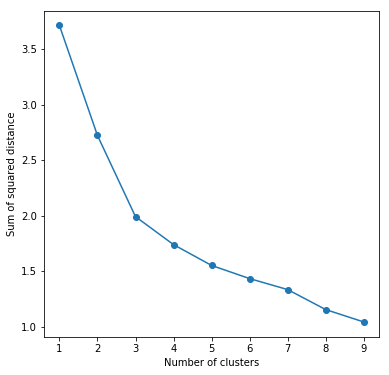

In [193]:
#Run the KMeans algorithm 

sse=[]
list_k=list(range(1,10))

for k in list_k:
    km=KMeans(n_clusters=k)
    km.fit(tor_cluster)
    sse.append(km.inertia_)
    
# Plot sse against k
plt.figure(figsize=(6,6))
plt.plot(list_k,sse,'-o')
plt.xlabel('Number of clusters')
plt.ylabel("Sum of squared distance")

It seems like k=3 is not a bad choice. Re-run the algorithm with K=3

In [194]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Let's add the cluster label into the dataframe tor_ven_onehot_grouped.

In [195]:
# add clustering labels
toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [196]:
toronto_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Café,Restaurant,Farmers Market,Beer Bar,Seafood Restaurant,Italian Restaurant
1,2,"Brockton , Parkdale Village , Exhibition Place",Café,Coffee Shop,Breakfast Spot,Gym,Bakery,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant
2,2,Business reply mail Processing CentrE,Yoga Studio,Auto Workshop,Park,Comic Shop,Pizza Place,Restaurant,Burrito Place,Brewery,Skate Park,Light Rail Station
3,2,"CN Tower , King and Spadina , Railway Lands , ...",Airport Service,Airport Lounge,Airport Terminal,Bar,Harbor / Marina,Coffee Shop,Boat or Ferry,Rental Car Location,Boutique,Sculpture Garden
4,2,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Japanese Restaurant,Spa,Gym / Fitness Center,Burger Joint,Bubble Tea Shop,Ice Cream Shop


In [197]:
# merge toronto_venues_sorted with Bor_Tor to add latitude/longitude for each neighborhood
Bor_Tor_Merged = Bor_Tor.join(toronto_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Bor_Tor_Merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,2,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Theater,Event Space
1,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Diner,Yoga Studio,Creperie,Music Venue,Mexican Restaurant,Juice Bar,Italian Restaurant,Hobby Shop,Fried Chicken Joint
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Cosmetics Shop,Tea Room,Ramen Restaurant,Bookstore
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,Restaurant,Italian Restaurant,Beer Bar,Clothing Store,American Restaurant,Diner,Gastropub
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Neighborhood_y,Coffee Shop,Health Food Store,Pub,Trail,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Café,Restaurant,Farmers Market,Beer Bar,Seafood Restaurant,Italian Restaurant
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Japanese Restaurant,Spa,Gym / Fitness Center,Burger Joint,Bubble Tea Shop,Ice Cream Shop
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2,Grocery Store,Café,Park,Gas Station,Baby Store,Candy Store,Italian Restaurant,Athletics & Sports,Restaurant,Diner
8,M5H,Downtown Toronto,"Richmond , Adelaide , King",43.650571,-79.384568,2,Coffee Shop,Restaurant,Café,Gym,Bakery,Thai Restaurant,Lounge,Cosmetics Shop,Bar,Concert Hall
9,M6H,West Toronto,"Dufferin , Dovercourt Village",43.669005,-79.442259,2,Pizza Place,Pharmacy,Bakery,Grocery Store,Supermarket,Bank,Middle Eastern Restaurant,Bar,Café,Park


<h2> Finally, let's visualize the map!

In [198]:
#Lets get the coordinates of Toronto
address="Toronto"
geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [199]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Bor_Tor_Merged['Latitude'], Bor_Tor_Merged['Longitude'], Bor_Tor_Merged['Neighborhood'], Bor_Tor_Merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters